In [ ]:
import os
import glob
import math
import shutil
import numpy as np
from PIL import Image
from astropy.io import fits
from datetime import datetime

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from scipy import fft, ndimage
from sklearn.cluster import MeanShift
from skimage import filters, morphology, feature, transform, measure

# Functions

## Calculation Routines

In [ ]:
def get_val(array, percent, abs_percent=True):
    array = array[~np.isnan(array)]
    
    if abs_percent:
        min_val = np.min(array)
        max_val = np.max(array)
        array_range = max_val - min_val
        val = percent/100 * array_range + min_val
    else:
        max_val = np.max(array)
        val = max_val * percent/100
    
    return val


def get_percent(array, val, abs_percent=True):
    array = array[~np.isnan(array)]
    
    if abs_percent:
        min_val = np.min(array)
        max_val = np.max(array)
        array_range = max_val - min_val
        percent = (val - min_val)/array_range * 100
    else:
        max_val = np.max(array)
        percent = val/max_val * 100
    
    return percent


def get_peak_percent(array, skip_zero=False):
    hist, edges = get_hist(array)
    
    if skip_zero:
        peak_i = np.argmax(hist[1:])
    else:
        peak_i = np.argmax(hist)
    return (edges[peak_i] + edges[peak_i+1])/2


def get_percent_to_peak_percent(array, percent_to_peak):
    percent_of_zero_val = get_percent(array, 0)
    peak_percent = get_peak_percent(array, skip_zero=True)
    
#     print((percent_of_zero_val, peak_percent))

    return percent_to_peak/100*(peak_percent - percent_of_zero_val) + \
        percent_of_zero_val


def get_hist(array, n=1000):
    """Get counts in each of n bins and a list of bin edges normalized as % of max value"""
    array = array[~np.isnan(array)]
    min_val = np.min(array)
    max_val = np.max(array)
    
    histogram, bin_edges = np.histogram(array, bins=n, range=(min_val,max_val))
    # bin_edges = np.hstack((bin_edges[bin_edges < 0]/abs(min_val)*100,
    #                       bin_edges[bin_edges >= 0]/max_val*100))
    array_range = max_val - min_val
    bin_edges = 100 / array_range * (bin_edges - min_val)
    
    return histogram, bin_edges

### Extraction

In [ ]:
src_folder = '../CHS_DETECT/'

def extract_fits(file_num, src_folder=src_folder):
    fits_list = glob.glob(src_folder + 'He/*.fts')
    fits_list.sort()
        
    he_fits_files = [fits.open(fits_path) for fits_path in fits_list]
    he_fits = he_fits_files[file_num]

    # Flip data to visualize arrays as images
    eqw = np.flip(he_fits[0].data[0], axis=0)
    continuum = np.flip(he_fits[0].data[1], axis=0)
    try:
        cloud = np.flip(he_fits[0].data[2], axis=0)
    except:
        cloud = np.zeros_like(continuum)
    
    date = datetime.strptime(he_fits[0].header['DATE'], 
                             '%Y-%m-%dT%H:%M:%S')
    
    try:
        titles = [he_fits[0].header[f'IMTYPE{i}'] for i in range(1,4)]
    except:
        titles = [f'Array {i}' for i in range(1,4)]
        
    return eqw, continuum, cloud, date, titles


def extract_euv(file_num, src_folder=src_folder):
    euv_list = glob.glob(src_folder + 'EUV/*.png')
    euv_list.sort()
    euv = Image.open(euv_list[file_num])
    
    return euv
    

def edit_eqw(eqw, peak_count_cutoff_percent=0.1):
    """
    Args
        peak_count_cutoff_percent: Vertical cutoff for histogram
            counts below a percentage
    """
    eqw_nan = np.where(eqw == 0, np.NaN, eqw)

    hist, edges = get_hist(eqw_nan)
    max_count = np.max(hist)

    cutoff = max_count*peak_count_cutoff_percent/100
    cutoff_edges = np.where(hist > cutoff, get_val(eqw_nan, edges[:-1]), 0)

#     eqw_high_cut = np.clip(eqw_nan, np.min(eqw), np.max(cutoff_edges))
    eqw_high_cut = np.where(eqw > np.max(cutoff_edges), np.NaN, eqw_nan)

    eqw_band_cut = np.clip(eqw_high_cut, np.min(cutoff_edges), np.max(cutoff_edges))
#     eqw_band_cut = np.where(eqw < np.min(cutoff_edges), np.NaN, eqw_high_cut)
    
    return eqw_band_cut, eqw_high_cut, eqw_nan

### Candidates

In [ ]:
def morph(array, open_radius, close_radius=None, close_first=False,
          grey=False):
    if close_radius == None:
        close_radius = open_radius
        
    if grey:
        if close_first:
            im_1 = morphology.closing(array, morphology.disk(close_radius))
            im_2 = morphology.opening(im_1, morphology.disk(open_radius))
        else:
            im_1 = morphology.opening(array, morphology.disk(open_radius))
            im_2 = morphology.closing(im_1, morphology.disk(close_radius))
    else:
        if close_first:
            im_1 = morphology.binary_closing(array, morphology.disk(close_radius))
            im_2 = morphology.binary_opening(im_1, morphology.disk(open_radius))
        else:
            im_1 = morphology.binary_opening(array, morphology.disk(open_radius))
            im_2 = morphology.binary_closing(im_1, morphology.disk(close_radius))
    
    return im_2, im_1


def fill_rm(array, min_size, rm_first=False):
    if rm_first:
        im_1 = morphology.remove_small_objects(array, min_size=min_size)
        im_2 = ndimage.binary_fill_holes(im_1)
    else:
        im_1 = ndimage.binary_fill_holes(array)
        im_2 = morphology.remove_small_objects(im_1, min_size=min_size)
    
    return im_2, im_1


def get_holes_mask(array, thresh_percent,
                   open_radius=8, close_first=False, grey=False,
                   min_size=15_000):
    bound = get_val(array, thresh_percent)
    
    if grey:
        holes_mask = morph(array, open_radius=open_radius,
                           close_first=close_first, grey=grey)[0]
        holes_mask = np.where(holes_mask > bound, 1, 0)
    else:
        holes_mask = np.where(array > bound, 1, 0)
        holes_mask = morph(holes_mask, open_radius=open_radius,
                           close_first=close_first, grey=grey)[0]
        
    holes_mask = fill_rm(holes_mask, min_size=min_size)[0]

    return holes_mask


def get_masked_candidates(array, holes_mask):
    inverted_holes_mask = np.where(holes_mask == 1, 0, 1)

    masked_candidates = np.ma.array(array, mask=inverted_holes_mask)
    
    return masked_candidates


def pool(array, size, pool_type):
    """pool_type: 'min' 'median' or 'max'
    """
    if pool_type=='min':
        func = np.min
    elif pool_type=='median':
        func = np.median
    elif pool_type=='max':
        func = np.max
        
    return measure.block_reduce(
        array, block_size=(size, size), func=func)

### Ensemble

In [ ]:
empty_disk_val = -25

def get_ensemble(array, percent_of_peak_list, radius_list, grey=False):
    ensemble_size = len(percent_of_peak_list) * len(radius_list)
    confidence_list = [(c + 1)*100/ensemble_size
                       for c in range(ensemble_size)]

    thresh_percent_list = [get_percent_to_peak_percent(
        array, percent_to_peak=percent_of_peak)
                           for percent_of_peak in percent_of_peak_list]
    
    holes_mask_list = [get_holes_mask(array, thresh_percent=thresh_percent,
                                      open_radius=radius, grey=grey,
                                      min_size=5000)
                       for thresh_percent in thresh_percent_list
                       for radius in radius_list]

    ensemble_map = np.where(~np.isnan(array), empty_disk_val, np.nan)
    
    for holes_mask, mask_num in zip(holes_mask_list, range(ensemble_size)):
        ensemble_map = np.where(holes_mask == 1, 
                                mask_num*100/(ensemble_size - 1), ensemble_map)
        
    return ensemble_map, holes_mask_list, confidence_list

### Selection

In [ ]:
def get_hole_im_list(array, labeled_candidate_holes, num_holes):
    hole_im_list = [np.where(labeled_candidate_holes == hole_num + 1, 
                             array, np.NaN)
                    for hole_num in range(num_holes)]
    return hole_im_list


def get_hole_medians(hole_im_list):    
    medians = [np.median(hole_im[~np.isnan(hole_im)])
               for hole_im in hole_im_list]
    return medians


def get_hole_band_widths(hole_im_list):    
    bound_list = [np.percentile(hole_im[~np.isnan(hole_im)], [5, 95])
                  for hole_im in hole_im_list]
    
    hole_band_widths = [bounds[1] - bounds[0]
                        for bounds
                        in bound_list]
    return hole_band_widths


def print_holes_metrics(num_holes, sorted_candidate_nums, metrics):
    for i in range(num_holes):
        if sorted_candidate_nums[i] < 10:
            hole_num = f'0{sorted_candidate_nums[i]}'
        else:
            hole_num = sorted_candidate_nums[i]
        if (i + 1) % 5 == 0:
            end_str = '\n'
        else:
            end_str = '  '
        print(f'Hole {hole_num}: {metrics[i]:.1f}', end=end_str)

## Plotting Routines

In [ ]:
oldcmp = cm.get_cmap('PuBuGn', 256)
newcolors = oldcmp(np.linspace(0, 1, 256))
newcolors = newcolors[20:]

background = np.array([1, 1, 1, 1])
newcolors[:1, :] = background
newcmp = ListedColormap(newcolors)

def plot_thresholds(array, bounds, threshold_type='band', abs_percent=True):
    """Plot image array, its histogram, and 3 thresholded images
    with their histograms.
    
    Args
        array: image as Numpy array
        bounds: list of threshold bounds from 0-100 %
            List of lists of lower and upper threshold bounds from 0-100 %
            for 'band' threshold type
        threshold_type:
            'lower' to disregard values below bounds 
            'upper' to disregard values above bounds
            'band' to disregard values outside bounds
        abs_percent: Specify as false to take bounds relative to 0 value
    """
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 15))
    ax = axes.ravel()

    ax[0].imshow(array, cmap=plt.cm.gray)
    hist, edges = get_hist(array)
    ax[1].set_title('Histogram', fontsize=24)
    ax[1].plot(edges[0:-1], hist)

    for i in range(3):
        img_i = (i + 1)*2
        hist_i = (i + 1)*2 + 1

        ax[hist_i].semilogy(edges[0:-1], hist)
        
        if threshold_type == 'band':
            lower_percent = bounds[0][i]
            upper_percent = bounds[1][i]
            
            lower_bound = get_val(array, lower_percent, abs_percent=abs_percent)
            upper_bound = get_val(array, upper_percent, abs_percent=abs_percent)
            
            lower_line_percent = get_percent(array, lower_bound)
            upper_line_percent = get_percent(array, upper_bound)
            
            ax[hist_i].axvline(lower_line_percent, color='r')
            ax[hist_i].axvline(upper_line_percent, color='r')
            
            ax[hist_i].set_title((f'Band: {lower_percent:.2f}-' +
                                  f'{upper_percent:.2f}% | Semilog Histogram'),
                                 fontsize=24)
            edit = np.where((array > lower_bound) & (array < upper_bound), 1, 0)
            ax[hist_i].axvspan(lower_line_percent, upper_line_percent, 
                               color='y', alpha=0.1, lw=0)
        else:
            percent_bound = bounds[i]
            bound = get_val(array, percent_bound, abs_percent=abs_percent)
            
            line_percent = get_percent(array, bound)
            
            ax[hist_i].axvline(line_percent, color='r')

            if threshold_type == 'lower':
                ax[hist_i].set_title((f'Threshold: >{percent_bound:.2f}% ' +
                                     '| Semilog Histogram'),
                                     fontsize=24)
                edit = np.where(array > bound, 1, 0)
                ax[hist_i].axvspan(line_percent, np.max(edges), 
                                   color='y', alpha=0.1, lw=0)
            elif threshold_type == 'upper':
                ax[hist_i].set_title((f'Threshold: <{percent_bound:.2f}% ' +
                                     '| Semilog Histogram'),
                                     fontsize=24)
                edit = np.where(array < bound, 1, 0)
                ax[hist_i].axvspan(np.min(edges), line_percent, 
                                   color='y', alpha=0.1, lw=0)
        
        ax[img_i].imshow(edit)
        
        
def plot_hists(arrays, titles, ns=[1000,1000], semilogy=True):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
    ax = axes.ravel()

    ax[0].set_title(titles[0], fontsize=24)
    ax[0].imshow(arrays[0], cmap=plt.cm.gray)
    hist, edges = get_hist(arrays[0], n=ns[0])
    if semilogy:
        ax[1].semilogy(edges[0:-1], hist)
    else:
        ax[1].plot(edges[0:-1], hist)
        
    ax[2].set_title(titles[1], fontsize=24)
    ax[2].imshow(arrays[1], cmap=plt.cm.gray)
    hist, edges = get_hist(arrays[1], n=ns[1])
    if semilogy:
        ax[3].semilogy(edges[0:-1], hist)
    else:
        ax[3].plot(edges[0:-1], hist)


def plot_edge_thresholds(edge_list, edge_names, threshold):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 30))
    ax = axes.ravel()
    
    for i in range(3):
        edges_i = i*3
        hist_i = i*3 + 1
        thresh_i = i*3 + 2
        
        edge_im = edge_list[i]
        name = edge_names[i]
        
        ax[edges_i].set_title(name, fontsize=24)
        ax[edges_i].imshow(edge_im, cmap=plt.cm.gray)
        hist, edges = get_hist(edge_im)
        ax[hist_i].set_title('Semilog Histogram', fontsize=24)
        ax[hist_i].semilogx(edges[0:-1], hist)
        ax[thresh_i].imshow(np.where(edge_im > threshold, 1, 0), cmap=plt.cm.gray)

### Candidates

In [ ]:
def plot_candidates(array, holes_mask, date, num_holes, 
                    labeled_candidate_holes):
    fig, axes = plt.subplots(nrows=1, ncols=3, 
                             figsize=(30, 10))
    ax = axes.ravel()
    
    ax[0].imshow(array, cmap=plt.cm.gray)
    ax[0].set_title(datetime.strftime(date, "%b %d, %Y %H:%M"), fontsize=24)
    
    ax[1].imshow(array, cmap=plt.cm.afmhot)
    ax[1].contour(holes_mask, cmap=plt.cm.binary)
    ax[1].set_title(f'{num_holes} Holes', fontsize=24)
    
    ax[2].imshow(labeled_candidate_holes, cmap=newcmp)
        
        
def plot_comparison(array, holes_mask, date, num_holes, euv):
    fig, axes = plt.subplots(nrows=1, ncols=3, 
                             figsize=(30, 10))
    ax = axes.ravel()
    
    ax[0].imshow(array, cmap=plt.cm.gray)
    ax[0].set_title(datetime.strftime(date, "%b %d, %Y %H:%M"), fontsize=24)
    
    ax[1].imshow(euv)
    
    ax[2].imshow(array, cmap=plt.cm.afmhot)
    ax[2].contour(holes_mask, cmap=plt.cm.binary)
    ax[2].set_title(f'{num_holes} Holes', fontsize=24)

### Ensemble

In [ ]:
def plot_ims(im_1, im_2, im_3, titles=[]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    ax = axes.ravel()
    
    ax[0].imshow(im_1, cmap=plt.cm.gray)
    ax[1].imshow(im_2, cmap=plt.cm.gray)
    ax[2].imshow(im_3, cmap=plt.cm.gray)
    
    if titles:
        [ax[i].set_title(titles[i], fontsize=24)
         for i in range(3)]
    

def plot_ensemble(array, ensemble_map, confidence_list, 
                  title_list, holes_mask_list):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax = axes.ravel()
    
    ax[0].imshow(array, cmap=plt.cm.gray)
    ax[1].imshow(ensemble_map, cmap=plt.cm.magma)

    for row in range(math.ceil(len(holes_mask_list)/3)):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
        ax = axes.ravel()
        
        for col in range(3):
            i = 3*row + col
            if i + 1 > len(holes_mask_list):
                return

            title = f'{confidence_list[i]:.1f}% Confidence\n' + title_list[i]
            
            ax[col].set_title(title, fontsize=28)
            ax[col].imshow(holes_mask_list[i], cmap=plt.cm.gray)
            
            
def plot_ensemble_comparison(array, date, ensemble_map, euv):
    fig, axes = plt.subplots(nrows=1, ncols=3, 
                             figsize=(30, 10))
    ax = axes.ravel()
    
    ax[0].set_title(datetime.strftime(date, "%b %d, %Y %H:%M"), fontsize=24)
    ax[0].imshow(array, cmap=plt.cm.gray)

    ax[2].imshow(euv)

    ax[1].imshow(ensemble_map, cmap=plt.cm.magma)

### Selection

In [ ]:
def plot_hole_hists(array, masked_candidates, labeled_candidate_holes, 
                    num_holes, sort_type='', gradient=False):
    if gradient:
        candidate_edges = filters.sobel(masked_candidates)
        xlim_min = np.min(candidate_edges[~np.isnan(candidate_edges)])
        xlim_max = np.max(candidate_edges[~np.isnan(candidate_edges)])/8
    else:
        xlim_min = np.min(masked_candidates[~np.isnan(masked_candidates)])/4
        xlim_max = np.max(masked_candidates[~np.isnan(masked_candidates)])*2/3
    
    if gradient:
        hole_im_list = get_hole_im_list(
            candidate_edges, labeled_candidate_holes, num_holes)
    else:
        hole_im_list = get_hole_im_list(
            array, labeled_candidate_holes, num_holes)
        
    medians = get_hole_medians(hole_im_list)
    hole_band_widths = get_hole_band_widths(hole_im_list)
    
    if sort_type == 'median':
        sorted_candidate_nums = np.argsort(medians)
        if not gradient:
            sorted_candidate_nums = np.flip(sorted_candidate_nums)
    elif sort_type == 'width':
        sorted_candidate_nums = np.argsort(hole_band_widths)

    for r in range(math.ceil(num_holes/2)):
        fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(60, 10))
        ax = axes.ravel()
        
        for c in range(2):
            i = 2*r + c
            ax_i = 3*c
            if i + 1 > num_holes:
                return
            
            if not sort_type:
                hole_num = i
            else:
                hole_num = sorted_candidate_nums[i]
            
                
            hole_im = np.where(labeled_candidate_holes == hole_num + 1,
                               array, np.NaN)
            if gradient:
                hole_im = filters.sobel(hole_im)
                
            hole_contour = np.where(labeled_candidate_holes == hole_num + 1,
                                    1, 0)

            y, x = np.where(~np.isnan(hole_im))
            hole_focus = hole_im[np.min(y) - 10:np.max(y) + 10,
                                 np.min(x) - 10:np.max(x) + 10]
                
            unique_val_num = np.unique(hole_focus).size
            hist, edges = np.histogram(hole_focus[~np.isnan(hole_focus)],
                                       bins=int(unique_val_num/1000))
            
            ax[ax_i].set_title(f'Hole {hole_num + 1}', fontsize=32)
            ax[ax_i].imshow(array, cmap=plt.cm.afmhot)
            ax[ax_i].contour(hole_contour, cmap=plt.cm.binary)
                
            ax[ax_i + 1].set_title(
                f'Median: {medians[hole_num]:.1f}', fontsize=32)
            
            if gradient:
                ax[ax_i + 1].imshow(hole_focus)
            else:
                ax[ax_i + 1].imshow(hole_focus, cmap=plt.cm.magma)

            ax[ax_i + 2].set_title(
                f'90% Band width: {hole_band_widths[hole_num]:.1f}',
                                                    fontsize=32)
            ax[ax_i + 2].bar(edges[0:-1], hist)
            ax[ax_i + 2].set_xlim([xlim_min, xlim_max])
            

def plot_metric_bars(ax, num_holes, metrics,
                     title, median=False, high_cutoff=False, gradient=False):
    metrics_median = np.percentile(metrics, 50)
    if high_cutoff:
        candidate_metrics = [metric for metric in metrics
                             if metric > metrics_median]
    else:
        candidate_metrics = [metric for metric in metrics
                             if metric < metrics_median]
    
    metric_diffs = np.diff(candidate_metrics)
    max_diff = np.max(np.abs(metric_diffs))/metrics_median*100
    
    max_diff_i = np.argmax(np.abs(metric_diffs))
    cutoff = np.mean([metrics[max_diff_i], metrics[max_diff_i + 1]])
    
    if high_cutoff:
        selected_hole_num = np.count_nonzero(metrics > cutoff)
    else:
        selected_hole_num = np.count_nonzero(metrics < cutoff)
    
    ax.set_title(f'{title}\n Max Difference: {max_diff:.1f}%', fontsize=28)
    ax.set_xlabel('Candidates', fontsize=24)
    
    if median:
        ax.set_ylabel('Median', fontsize=24)
    else:
        ax.set_ylabel('Central 90% Band Width', fontsize=24)
    
    ax.plot([0.5, num_holes+0.5], [cutoff, cutoff], 
               linestyle='--', color='k', linewidth=3)
    
    if gradient:
        ax.bar(list(range(1,num_holes + 1)), metrics, color='#3e4989')
        ax.bar(list(range(1,selected_hole_num+1)), 
               metrics[:selected_hole_num], color='#6ece58')
    else:
        ax.bar(list(range(1,num_holes + 1)), metrics, color='#721f81')
        ax.bar(list(range(1,selected_hole_num+1)), 
           metrics[:selected_hole_num], color='#fd9668')
    
    return max_diff
    
    
def plot_selection_metrics(array, date, num_holes, holes_mask,
                           bright_medians, bright_band_widths, 
                           gradient_medians, gradient_band_widths):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50, 10))
    ax = axes.ravel()

    ax[0].set_title(datetime.strftime(date, "%b %d, %Y %H:%M"), fontsize=24)
    ax[0].imshow(array, cmap=plt.cm.afmhot)
    ax[0].contour(holes_mask, cmap=plt.cm.binary)

    b_median_diff = plot_metric_bars(
        ax[1], num_holes, bright_medians, 'Brightness Median',
        median=True, high_cutoff=True)
    b_width_diff = plot_metric_bars(
        ax[2], num_holes, bright_band_widths, 'Brightness Spread')
    g_median_diff = plot_metric_bars(
        ax[3], num_holes, gradient_medians, 'Gradient Intensity Median', 
        median=True, gradient=True)
    g_width_diff = plot_metric_bars(
        ax[4], num_holes, gradient_band_widths, 'Gradient Intensity Spread',
        gradient=True)
    
    return b_median_diff, b_width_diff, g_median_diff, g_width_diff

# Extract Data

In [ ]:
# 0-9
file_num = 9

eqw, continuum, cloud, date, titles = extract_fits(file_num=file_num)
print(date)

eqw_visual = np.clip(eqw, -50, 50)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
ax = axes.ravel()
    
ax[0].set_title(titles[0], fontsize=24)
ax[0].imshow(eqw_visual, cmap=plt.cm.RdBu)
ax[1].set_title(titles[1], fontsize=24)
ax[1].imshow(continuum, cmap=plt.cm.afmhot)
ax[2].set_title(titles[2], fontsize=24)
ax[2].imshow(cloud, cmap=plt.cm.gray)

## Rename FITS & EUV

In [ ]:
# Extract FITS data
fits_list = glob.glob('Desktop/CHS_DETECT/*.fts')
he_fits_list = [fits.open(fits_path) for fits_path in fits_list]
date_list = [datetime.strptime(he_fits[0].header['DATE'], '%Y-%m-%dT%H:%M:%S')
             for he_fits in he_fits_list]

# Sort FITS list by date
fits_array = np.array(fits_list)
dates = np.array(date_list)
inds = dates.argsort()
sorted_fits_list = fits_array[inds]
date_list.sort()

# Extract EUV image list
euv_list = glob.glob('Desktop/CHS_DETECT/Screen*')
euv_list.sort()

# Rename FITS
fits_dst = 'Desktop/CHS_DETECT/Renamed_FITS'
if not os.path.isdir(fits_dst):
    os.mkdir(fits_dst)
    
new_fits_list = [datetime.strftime(date, "%Y_%m_%d_%H%M.fts")
                 for date in date_list] 
for fits_path, new_fits in zip(sorted_fits_list, new_fits_list):
    shutil.copy(fits_path, os.path.join(fits_dst, new_fits))

# Rename EUV
euv_dst = 'Desktop/CHS_DETECT/Renamed_EUV'
if not os.path.isdir(euv_dst):
    os.mkdir(euv_dst)
    
new_euv_list = [datetime.strftime(date, "%Y_%m_%d_%H%M.png")
                for date in date_list] 
for euv_path, new_euv in zip(euv_list, new_euv_list):
    shutil.copy(euv_path, os.path.join(euv_dst, new_euv))

## Modify Arrays

### EQW Edits

 - Equivalent Width Threshold: Upper threshold on EQW to zero very high disk edge 
 - EQW Threshold Image: Continuum + EQW Edit

In [ ]:
eqw_band_cut, eqw_high_cut, eqw_nan = edit_eqw(eqw, peak_count_cutoff_percent=0.1)

arrays = [eqw, eqw_nan, eqw_high_cut, eqw_band_cut]
titles = ['EQW', 'EQW NaN', 'EQW High Cut', 'EQW Band Cut']

plot_hists(arrays[0:2], titles[0:2], semilogy=True)
plot_hists(arrays[2:4], titles[2:4], semilogy=True)

In [ ]:
upper_bound = 2000
eqw_thresh = np.where(eqw < upper_bound, eqw, 0)
eqw_thresh_im = continuum + eqw_thresh

arrays = [np.log10(eqw_nan + abs(np.min(eqw_thresh_im[~np.isnan(eqw_nan)])) + 1), eqw_nan]
titles = ['EQW Threshold', 'EQW Threshold Image']
plot_hists(arrays, titles)

In [ ]:
# Outdated Approach: Multiply by a binary disk to mask off disk values
edge_pad = 90

radius = len(im)/2 - edge_pad
disk = morphology.disk(radius)

# Create and center disk mask 
pad_width = int((len(eqw) - len(disk) - 1)/2)
disk_mask = np.pad(disk, pad_width=pad_width)
if len(eqw) > len(disk_mask):
    disk_mask = np.pad(disk_mask, pad_width=(0,1))

# Apply disk mask
eqw_disk = eqw*disk_mask
plt.imshow(eqw_disk)

### Intensity Edits and Addition

 - Raw Image: Continuum + EQW
 - Continuum Edit: Lower bound threshold to NaN off disk values
   - Iterates until negative values appear
     - Negative values indicate continuum disk has been reduced to where negative EQW adds with NaN
   - Assumes EQW will have negative values near edge of disk
     - Replace with hough transform to detect circle and threshold off disk?
values
 - Image: Continuum Edit + EQW Edit

In [ ]:
raw_im = continuum + eqw


cont_edit_im = raw_im
no_negative_vals = len(np.flatnonzero(cont_edit_im < 0)) == 0
lower_bound = 0

while no_negative_vals:
    cont_edit = np.where(continuum > lower_bound, continuum, 0)
    cont_edit_im = cont_edit + eqw
    
    # Update conditional and increase threshold
    no_negative_vals = len(np.flatnonzero(cont_edit_im < 0)) == 0
    lower_bound += 10
    
# Step threshold down to reach limit before negative values appear 
lower_bound -= 10
cont_edit = np.where(continuum > lower_bound, continuum, np.NaN)

cont_edit_im = cont_edit + eqw_band_cut


im = cont_edit + eqw

In [ ]:
arrays = [cont_edit, cont_edit_im, raw_im, im]
titles = ['Continuum Edit', 'Continuum Edit Image', 'Raw',
          'Image']

plot_hists(arrays[0:2], titles[0:2])
plot_hists(arrays[2:4], titles[2:4])

## Linear Combinations

In [ ]:
percent_range = [10, 20, 30, 40]

arrays = [cont_edit*percent/100 + eqw_band_cut for percent in percent_range]
# arrays = [array + abs(np.min(array[~np.isnan(array)])) for array in arrays]
arrays = [np.where(array < 0, 0, array) for array in arrays]
titles = [f'{percent}% of Continuum Combo' for percent in percent_range]

plot_hists(arrays[0:2], titles[0:2])
plot_hists(arrays[2:4], titles[2:4])

In [ ]:
im_10p = cont_edit*10/100 + eqw_band_cut
im_10p = np.where(im_10p < 0, 0, im_10p)
im_20p = cont_edit*20/100 + eqw_band_cut
im_20p = np.where(im_20p < 0, 0, im_20p)

## SPoCA CHs

In [ ]:
from sunpy.net import attrs as a
from sunpy.net import Fido
# sunpy, zeep, drms

In [ ]:
tstart = '2015/03/30 00:00:00'
tend = '2015/04/01 00:00:00'
event_type = 'CH'
result = Fido.search(a.Time(tstart,tend), a.hek.EventType(event_type), 
                     a.hek.FRM.Name == 'SPoCA')

# Visualization

## Continuum

### Visualization

 - Off disk white corners are 0
 - Off disk dark regions are >0
   - Visualized in histogram hill centered on 10<sup>-2</sup>
   - Should be dropped to 0

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(np.log(continuum), cmap=plt.cm.afmhot)
hist, edges = get_hist(continuum)
ax[1].semilogx(edges[0:-1], hist)

### Thresholds

In [ ]:
plot_thresholds(continuum, bounds=[0, 1, 20], threshold_type='lower')

In [ ]:
plot_thresholds(continuum, bounds=[55, 85, 90], threshold_type='lower')

In [ ]:
plot_thresholds(continuum, bounds=[90, 60, 10], threshold_type='upper')

In [ ]:
plot_thresholds(continuum, bounds=[5, 2, 1], threshold_type='upper')

## EQW

### Visualization

 - Red regions are <0 and indicate absorption
   - Strongest in active regions
 - Blue regions are >0 and indicate emission
   - Strongest on disk edge (see lower and upper thresholds at 100)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax = axes.ravel()

lower_bound = -100
upper_bound = 100

ax[0].imshow(np.clip(eqw, lower_bound, upper_bound), cmap=plt.cm.RdBu)
hist, edges = get_hist(eqw)
ax[1].semilogy(edges[0:-1], hist)

lower_percent = get_percent(eqw, lower_bound)
upper_percent = get_percent(eqw, upper_bound)

ax[1].axvline(lower_percent, color='r')
ax[1].axvline(upper_percent, color='r')
ax[1].axvspan(lower_percent, upper_percent, color='y', alpha=0.1, lw=0)

### Thresholds

In [ ]:
tresh_percent_list = [get_percent_to_peak_percent(eqw_band_cut, 
                                                  percent_to_peak=percent_of_peak)
                      for percent_of_peak in [75, 100, 125]]
plot_thresholds(eqw_band_cut, bounds=tresh_percent_list, threshold_type='lower',
                abs_percent=True)

In [ ]:
plot_thresholds(eqw, bounds=[-18, -16, 0], threshold_type='lower',
                abs_percent=False)

In [ ]:
plot_thresholds(eqw, bounds=[2, 4, 6], threshold_type='lower',
                abs_percent=False)

In [ ]:
plot_thresholds(eqw, bounds=[9, 8, 5], threshold_type='upper',
                abs_percent=False)

In [ ]:
plot_thresholds(eqw, bounds=[0, -10, -20], threshold_type='upper',
                abs_percent=False)

In [ ]:
band_bounds = [[0,-20,4],
               [9, 0, 9]]
plot_thresholds(eqw, bounds=band_bounds, threshold_type='band',
                abs_percent=False)

## Raw Intensity

In [ ]:
peak_p = get_peak_percent(raw_im)
plot_thresholds(raw_im, bounds=[40, 80, peak_p], threshold_type='lower')

## Processed Intensity

In [ ]:
peak_p = get_peak_percent(im)
plot_thresholds(im, bounds=[60, 80, peak_p], threshold_type='lower')

## Linear Combos

In [ ]:
peak_p = get_peak_percent(im_10p, skip_zero=True)
plot_thresholds(im_10p, bounds=[65, peak_p, 75], threshold_type='lower')

In [ ]:
peak_p = get_peak_percent(im_20p)
plot_thresholds(im_20p, bounds=[75, peak_p, 85], threshold_type='lower')

# Shape Processing

## Morphology

### Open, Close

In [ ]:
# 0-9
file_num = 9

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]
edit_im = eqw_band_cut

thresh_percent = get_percent_to_peak_percent(
        edit_im, percent_to_peak=90)
bound = get_val(edit_im, thresh_percent)
thresh_im = np.where(edit_im > bound, 1, 0)

for open_radius_percent in [0.5, 0.6, 0.7, 0.8]:
    open_radius = int(open_radius_percent/100 * edit_im.shape[0])
    im_2, im_1 = morph(thresh_im, open_radius=open_radius)
    
    titles = ['', f'{open_radius}px Radius', '']
    plot_ims(edit_im, im_1, im_2, titles)

### Open, Close with Different Radii

In [ ]:
edit_im = im_10p

peak_p = get_peak_percent(edit_im, skip_zero=True)
bound = get_val(edit_im, peak_p)
edit_im = np.where(edit_im > bound, 1, 0)

im_2, im_1 = morph(edit_im, open_radius=8, close_radius=10)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=8, close_radius=15)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=8, close_radius=20)
plot_ims(edit_im, im_1, im_2)

### Close, Open

In [ ]:
edit_im = eqw_band_cut
peak_p = get_peak_percent(edit_im, skip_zero=True)
bound = get_val(edit_im, peak_p)
edit_im = np.where(edit_im > bound, 1, 0)

im_2, im_1 = morph(edit_im, open_radius=4, close_first=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=10, close_first=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=15, close_first=True)
plot_ims(edit_im, im_1, im_2)

### Grey Morphology before Threshold

In [ ]:
# 0-9
file_num = 9

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]
edit_im = eqw_band_cut

open_radius = 10
close_radius = open_radius

im_2, im_1 = morph(edit_im, open_radius=5, grey=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=10, grey=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = morph(edit_im, open_radius=15, grey=True)
plot_ims(edit_im, im_1, im_2)

## Binary Hole Processing

### Fill, Remove

In [ ]:
# 0-9
file_num = 9

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

edit_im = eqw_band_cut
thresh_percent = get_percent_to_peak_percent(edit_im, percent_to_peak=100)
bound = get_val(edit_im, thresh_percent)
edit_im = np.where(edit_im > bound, 1, 0)

edit_im = morph(edit_im, open_radius=5)[0]

im_2, im_1 = fill_rm(edit_im, min_size=5_000)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = fill_rm(edit_im, min_size=12_500)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = fill_rm(edit_im, min_size=20_000)
plot_ims(edit_im, im_1, im_2)

### Remove, Fill

In [ ]:
edit_im = im_10p
peak_p = get_peak_percent(edit_im, skip_zero=True)
bound = get_val(edit_im, peak_p)
edit_im = np.where(edit_im > bound, 1, 0)

edit_im = morph(edit_im, open_radius=8)[0]

im_2, im_1 = fill_rm(edit_im, min_size=5000, rm_first=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = fill_rm(edit_im, min_size=15000, rm_first=True)
plot_ims(edit_im, im_1, im_2)
im_2, im_1 = fill_rm(edit_im, min_size=25000, rm_first=True)
plot_ims(edit_im, im_1, im_2)

# Pooling

## Fixed Morphological Radius

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

open_radius = 6
min_size_percent = 0.2

pool_sizes = [2,4,6]
    
for pool_type in ['min', 'median', 'max']:

    pooled_ims = [pool(eqw_band_cut, size=i, pool_type=pool_type)
                  for i in pool_sizes]

    thresh_percents = [get_percent_to_peak_percent(
        pooled_im, percent_to_peak=90)
                       for pooled_im in pooled_ims]
    min_sizes = [int(min_size_percent/100 * pooled_im.shape[0]**2)
                 for pooled_im in pooled_ims]
    
    holes_mask_list = [get_holes_mask(
        pooled_im, thresh_percent=thresh_percent, 
        open_radius=open_radius, min_size=min_size)
                       for pooled_im, thresh_percent, min_size
                       in zip(pooled_ims, thresh_percents, min_sizes)]
    
    titles = [f'{pool_type[0].upper()}{pool_type[1:]} Pooling \n' +\
              f'{pool_size}px Window Length'
              for pool_size in pool_sizes]
              
    plot_ims(holes_mask_list[0], holes_mask_list[1], holes_mask_list[2], titles)

## Morphological Radius Scaling Down with Pooling

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

percent_to_peak = 100
open_radius_percent = 0.6
min_size_percent = 0.2

pool_sizes = [2,4,6]

thresh_percent = get_percent_to_peak_percent(
    edit_im, percent_to_peak=percent_to_peak)
open_radius = int(open_radius_percent/100 * eqw_band_cut.shape[0])
min_size = int(min_size_percent/100 * eqw_band_cut.shape[0]**2)

holes_mask = get_holes_mask(eqw_band_cut, thresh_percent=thresh_percent,
                            open_radius=open_radius, min_size=min_size)
plot_ims(eqw_band_cut, holes_mask, [[0,0],[0,0]])

for pool_type in ['min', 'median', 'max']:

    pooled_ims = [pool(eqw_band_cut, size=i, pool_type=pool_type)
                  for i in pool_sizes]

    thresh_percents = [get_percent_to_peak_percent(
        pooled_im, percent_to_peak=percent_to_peak)
                       for pooled_im in pooled_ims]
    radii = [int(open_radius_percent/100 * pooled_im.shape[0])
             for pooled_im in pooled_ims]
    min_sizes = [int(min_size_percent/100 * pooled_im.shape[0]**2)
                 for pooled_im in pooled_ims]
    
    holes_mask_list = [get_holes_mask(
        pooled_im, thresh_percent=thresh_percent, 
        open_radius=radius, min_size=min_size)
                       for pooled_im, thresh_percent, radius, min_size
                       in zip(pooled_ims, thresh_percents, radii, min_sizes)]
    
    titles = [f'{pool_type[0].upper()}{pool_type[1:]} Pooling \n' +\
              f'{pool_size}px Window Length'
              for pool_size in pool_sizes]
              
    plot_ims(holes_mask_list[0], holes_mask_list[1], holes_mask_list[2], titles)

# Candidate Holes

Initial Algorithm
1. EQW Pre-Processing
    - Work with EQW rather than intensity
        - Continuum overpowers EQW in Intensity = Continuum + EQW
            - Threshold becomes meaningless
    - Fill background with NaN
    - Band pass threshold
        - At % of peak histogram count: **0.1%**
        - Brightest Limb Values: Strong emission that does not indicate CHS presence
            - Introduce an unwanted ring in CHS mask
        - Darkest Region Values: Strong absorption from irrelevant active regions
            - Center image brightness for visualization
            - Thresholded off in CHS mask anyways
2. Threshold to create binary CHS mask
    - Arbitrary threshold options
        - At % from 0 value to peak histogram count value: **90%**
        - At peak histogram count
3. Process CHS mask to remove noise
    - Morphological open, close
        - Arbitrary structuring element disk radius: **5 px**
    - Fill small holes in CHS and remove small features
        - Arbitrary minimum size for small object removal: **10,000 px**
4. Produce labeled candidate holes
    - Visualize boundaries with a contour map
    - Labeled candidates are regions numbered 1 to number of CHS

## Extraction

### Threshold Before Processing

In [ ]:
# 0-9
file_num = 8

percent_to_peak = 90
open_radius_percent = 0.5
min_size_percent = 0.2

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

edit_im = eqw_band_cut

thresh_percent = get_percent_to_peak_percent(
    edit_im, percent_to_peak=percent_to_peak)
open_radius = int(open_radius_percent/100 * eqw_band_cut.shape[0])
min_size = int(min_size_percent/100 * eqw_band_cut.shape[0]**2)

holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                            open_radius=open_radius, min_size=min_size)

labeled_candidate_holes, num_holes = ndimage.label(holes_mask)
masked_candidates = get_masked_candidates(edit_im, holes_mask)

plot_candidates(edit_im, holes_mask, date, num_holes, labeled_candidate_holes)
plot_ims(edit_im, masked_candidates.mask, masked_candidates)

#### Pooling

In [ ]:
# 0-9
file_num = 8

pool_size = 2
percent_to_peak = 90
open_radius_percent = 0.6
min_size_percent = 0.2

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

pooled_im = pool(eqw_band_cut, size=pool_size, pool_type='min')

thresh_percent = get_percent_to_peak_percent(
    pooled_im, percent_to_peak=percent_to_peak)
open_radius = int(open_radius_percent/100 * pooled_im.shape[0])
min_size = int(min_size_percent/100 * pooled_im.shape[0]**2)

holes_mask = get_holes_mask(
    pooled_im, thresh_percent=thresh_percent, open_radius=6, 
    min_size=min_size)
holes_mask_im = Image.fromarray(holes_mask)
zoom_holes_mask = np.asarray(holes_mask_im.resize(
    (eqw_band_cut.shape[0], eqw_band_cut.shape[0])))

labeled_candidate_holes, num_holes = ndimage.label(holes_mask)
masked_candidates = get_masked_candidates(eqw_band_cut, zoom_holes_mask)

plot_candidates(eqw_band_cut, zoom_holes_mask, date, num_holes, labeled_candidate_holes)
plot_ims(pooled_im, masked_candidates.mask, masked_candidates)

### Threshold after Processing

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

edit_im = eqw_band_cut

thresh_percent = get_percent_to_peak_percent(edit_im, 
                                             percent_to_peak=90)

holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                            open_radius=8, grey=True,
                            min_size=10000)

labeled_candidate_holes, num_holes = ndimage.label(holes_mask)
masked_candidates = get_masked_candidates(edit_im, holes_mask)

plot_candidates(edit_im, holes_mask, date, num_holes, labeled_candidate_holes)
plot_ims(edit_im, masked_candidates.mask, masked_candidates)

## Candidates

In [ ]:
# 0-9
file_num = 8

percent_to_peak = 90
open_radius_percent = 0.6
min_size_percent = 0.2

eqw, date = extract_fits(file_num=file_num)[0:4:3]
eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

edit_im = eqw_band_cut

thresh_percent = get_percent_to_peak_percent(
    edit_im, percent_to_peak=percent_to_peak)
open_radius = int(open_radius_percent/100 * eqw_band_cut.shape[0])
min_size = int(min_size_percent/100 * eqw_band_cut.shape[0]**2)

holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                            open_radius=open_radius, min_size=min_size)

masked_candidates = get_masked_candidates(edit_im, holes_mask)
labeled_candidate_holes, num_holes = ndimage.label(holes_mask)

plot_hole_hists(edit_im, masked_candidates, labeled_candidate_holes, num_holes)

## Compare

In [ ]:
percent_to_peak = 100
open_radius_percent = 0.6
min_size_percent = 0.2

for file_num in range(10):
    eqw, date = extract_fits(file_num=file_num)[0:4:3]
    eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

    edit_im = eqw_band_cut
    
    thresh_percent = get_percent_to_peak_percent(
        edit_im, percent_to_peak=percent_to_peak)
    open_radius = int(open_radius_percent/100 * edit_im.shape[0])
    min_size = int(min_size_percent/100 * edit_im.shape[0]**2)
    
    holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                                open_radius=open_radius, min_size=min_size)
    num_holes = ndimage.label(holes_mask)[1]

    euv = extract_euv(file_num)

    plot_comparison(eqw_band_cut, holes_mask, date, num_holes, euv)

### Pool

In [ ]:
pool_size = 4
percent_to_peak = 100
open_radius_percent = 0.6
min_size_percent = 0.2

for file_num in range(10):
    eqw, date = extract_fits(file_num=file_num)[0:4:3]
    eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

    edit_im = pool(eqw_band_cut, size=pool_size, pool_type='min')

    thresh_percent = get_percent_to_peak_percent(
        edit_im, percent_to_peak=percent_to_peak)
    open_radius = int(open_radius_percent/100 * edit_im.shape[0])
    min_size = int(min_size_percent/100 * edit_im.shape[0]**2)

    holes_mask = get_holes_mask(
        edit_im, thresh_percent=thresh_percent, open_radius=open_radius, 
        min_size=min_size)
    holes_mask_im = Image.fromarray(holes_mask)
    zoom_holes_mask = np.asarray(holes_mask_im.resize(
        (eqw_band_cut.shape[0], eqw_band_cut.shape[0])))

    num_holes = ndimage.label(holes_mask)[1]

    euv = extract_euv(file_num)

    plot_comparison(eqw_band_cut, zoom_holes_mask, date, num_holes, euv)

# Ensemble

**Bright, smooth regions** indicate likelihood of a candidate being a CH

Ensemble Approach: Confidence map for initial segmentations
- Vary key algorithm parameters and assign high confidence to more "conservative" segmentations
    - Display of intra-algorithm uncertainty
- Parameters
    - Initial thresholds as % of histogram peak 
        - Higher thresholds require high brightness to "nominate" candidates
        - Current: **90, 100, & 110%**
    - Radius of disk structuring element for morphological open/closing 
        - Larger radii require greater coherence to "nominate" candidates
            - Nominates more blobby and less stringy regions
        - Current: **4, 6, 8px**
- Confidence
    - Assigned $\in$ (0%, 100%] via number of parameter options provided

## Threshold-Based

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

percent_of_peak_list = list(range(80,131,10))
radius_list = [5]

ensemble_map, holes_mask_list, confidence_list = get_ensemble(
    edit_im, percent_of_peak_list, radius_list)

title_list = [f'{percent_of_peak:d}% of Histogram Peak'
              for percent_of_peak, confidence 
              in zip(percent_of_peak_list, confidence_list)]

plot_ensemble(edit_im, ensemble_map, confidence_list, title_list, holes_mask_list)

## Radius-Based

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

percent_of_peak_list = [100]
radius_list = list(range(2,13,2))

ensemble_map, holes_mask_list, confidence_list = get_ensemble(
    edit_im, percent_of_peak_list, radius_list)

title_list = [f'{radius:d}px Radius'
              for radius, confidence 
              in zip(radius_list, confidence_list)]

plot_ensemble(edit_im, ensemble_map, confidence_list, title_list, holes_mask_list)

## Combined

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

percent_of_peak_list = list(range(90,111,10))
radius_list = list(range(4,9,2))

ensemble_map, holes_mask_list, confidence_list = get_ensemble(
    edit_im, percent_of_peak_list, radius_list)

title_list = [f'{percent_of_peak:d}% of Histogram Peak | {radius:d}px Radius'
              for percent_of_peak in percent_of_peak_list
              for radius in radius_list]

plot_ensemble(edit_im, ensemble_map, confidence_list, title_list, holes_mask_list)

In [ ]:
# 0-9
file_num = 8

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

percent_of_peak_list = list(range(90,111,10))
radius_list = list(range(4,9,2))

ensemble_map, holes_mask_list, confidence_list = get_ensemble(
    edit_im, percent_of_peak_list, radius_list, grey=True)

title_list = [f'{percent_of_peak:d}% of Histogram Peak | {radius:d}px Radius'
              for percent_of_peak in percent_of_peak_list
              for radius in radius_list]

plot_ensemble(edit_im, ensemble_map, confidence_list, title_list, holes_mask_list)

## EUV Comparison

In [ ]:
for file_num in range(10):
    eqw, date = extract_fits(file_num=file_num)[0:4:3]
    eqw_band_cut = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

    edit_im = eqw_band_cut
    
    percent_of_peak_list = list(range(90,111,10))
    radius_list = list(range(4,9,2))

    ensemble_map = get_ensemble(edit_im, percent_of_peak_list, radius_list)[0]

    euv = extract_euv(file_num)

    plot_ensemble_comparison(edit_im, date, ensemble_map, euv)

# Selection Metrics

Statistical Selection Approach: Probability map for candidates being CH's 
- Brightness Metrics
    - High central tendency in brightness
        1. Median of candidate brightness
- Smoothness Metrics
    - Low dispersion in brightness
        2. Central **90%** band width from histogram of candidate brightness
    - Low central tendency in gradient intensity
        3. Median of candidate intensity after Sobel operator
    - Low dispersion in gradient intensity
        4. Central **90%** band width from histogram of candidate intensity after Sobel operator

## Brightness

In [ ]:
# 0-9
file_num = 9

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

thresh_percent = get_percent_to_peak_percent(edit_im, percent_to_peak=90)

holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                            open_radius=5, min_size=10000)

masked_candidates = get_masked_candidates(edit_im, holes_mask)
labeled_candidate_holes, num_holes = ndimage.label(holes_mask)

hole_im_list = get_hole_im_list(edit_im, labeled_candidate_holes, num_holes)

In [ ]:
plot_hole_hists(edit_im, masked_candidates, labeled_candidate_holes, num_holes,
                sort_type='median')

In [ ]:
medians = get_hole_medians(hole_im_list)

sorted_candidate_nums = np.argsort(medians) + 1
sorted_candidate_nums = np.flip(sorted_candidate_nums)
medians.sort(reverse=True)

print('Brightness Medians')
print_holes_metrics(num_holes, sorted_candidate_nums, medians)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

plot_metric_bars(ax, num_holes, medians, 'Brightness Median', 
                 median=True, high_cutoff=True)

## Smoothness

In [ ]:
plot_hole_hists(edit_im, masked_candidates, labeled_candidate_holes, num_holes,
                sort_type='width')

In [ ]:
hole_band_widths = get_hole_band_widths(hole_im_list)
sorted_candidate_nums = np.argsort(hole_band_widths) + 1
hole_band_widths.sort()

print('Central 90% Band Widths of Brightness')
print_holes_metrics(num_holes, sorted_candidate_nums, hole_band_widths)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

plot_metric_bars(ax, num_holes, hole_band_widths, 'Brightness Spread')

### Gradient

In [ ]:
# 0-9
file_num = 9

eqw, date = extract_fits(file_num=file_num)[0:4:3]
edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]

thresh_percent = get_percent_to_peak_percent(edit_im, percent_to_peak=90)

holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                            open_radius=5, min_size=10000)

masked_candidates = get_masked_candidates(edit_im, holes_mask)
labeled_candidate_holes, num_holes = ndimage.label(holes_mask)

candidate_edges = filters.sobel(masked_candidates)
hole_im_list = get_hole_im_list(candidate_edges,
                                labeled_candidate_holes, num_holes)

### Central Tendency

In [ ]:
plot_hole_hists(edit_im, masked_candidates, labeled_candidate_holes, num_holes,
                sort_type='median', gradient=True)

In [ ]:
medians = get_hole_medians(hole_im_list)
sorted_candidate_nums = np.argsort(medians) + 1
medians.sort()

print('Gradient Intensity Medians')
print_holes_metrics(num_holes, sorted_candidate_nums, medians)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

plot_metric_bars(ax, num_holes, medians, 'Gradient Intensity Median',
                 gradient=True)

### Dispersion

In [ ]:
plot_hole_hists(edit_im, masked_candidates, labeled_candidate_holes, num_holes,
                sort_type='width', gradient=True)

In [ ]:
hole_band_widths = get_hole_band_widths(hole_im_list)
sorted_candidate_nums = np.argsort(hole_band_widths) + 1
hole_band_widths.sort()

print('Central 90% Band Widths of Gradient Intensity')
print_holes_metrics(num_holes, sorted_candidate_nums, hole_band_widths)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

plot_metric_bars(ax, num_holes, hole_band_widths, 'Gradient Spread',
                 gradient=True)

## Metric Comparison

In [ ]:
file_num = 10

b_median_avg_diff = 0
b_width_avg_diff = 0
g_median_avg_diff = 0
g_width_avg_diff = 0

for file_num in range(file_num):
    eqw, date = extract_fits(file_num=file_num)[0:4:3]
    edit_im = edit_eqw(eqw, peak_count_cutoff_percent=0.1)[0]
    
    thresh_percent = get_percent_to_peak_percent(edit_im, percent_to_peak=90)
    holes_mask = get_holes_mask(edit_im, thresh_percent=thresh_percent,
                                open_radius=5, min_size=10000)

    masked_candidates = get_masked_candidates(edit_im, holes_mask)
    labeled_candidate_holes, num_holes = ndimage.label(holes_mask)
    
    hole_im_list = get_hole_im_list(edit_im, labeled_candidate_holes, num_holes)
    
    bright_medians = get_hole_medians(hole_im_list)
    bright_medians.sort(reverse=True)
    
    bright_band_widths = get_hole_band_widths(hole_im_list)
    bright_band_widths.sort()
    
    candidate_edges = filters.sobel(masked_candidates)
    hole_im_list = get_hole_im_list(candidate_edges, 
                                    labeled_candidate_holes, num_holes)
    
    gradient_medians = get_hole_medians(hole_im_list)
    gradient_medians.sort()
    
    gradient_band_widths = get_hole_band_widths(hole_im_list)
    gradient_band_widths.sort()

    (b_median_diff, b_width_diff, 
     g_median_diff, g_width_diff) = plot_selection_metrics(
        edit_im, date, num_holes, holes_mask,
        bright_medians, bright_band_widths, 
        gradient_medians, gradient_band_widths)
    
    b_median_avg_diff += b_median_diff
    b_width_avg_diff += b_width_diff
    g_median_avg_diff += g_median_diff
    g_width_avg_diff += g_width_diff
    
print(f'Brightness Median Avg Max Diff: {b_median_avg_diff/file_num:.1f}%')
print(f'Brightness Width Avg Max Diff: {b_width_avg_diff/file_num:.1f}%')
print(f'Gradient Median Avg Max Diff: {g_median_avg_diff/file_num:.1f}%')
print(f'Gradient Width Avg Max Diff: {g_width_avg_diff/file_num:.1f}%')

Single Metric Selection: Binary selection of candidates as CH's
- Advance candidates with metrics below median of all candidates
- Select candidates below the largest jump
    - Jump refers to greatest difference in adjacent, sorted metrics

# Selection

Multi-Metric Selection: Probability map via generalized linear model 
- Logit link function mapping probability of CH $p_{CH}$ to linear model $LM$ of metrics
    - Aka logistic regression on linear model of metrics
- Linear Model Parameters
    - $\alpha$ intercept crossing $p_{CH} = 0.5$
    - $\beta_{i}$ coefficients on metrics
    - Metric Formulations
        - Metric rank among other candidates, normalized by number of candidates
        - Percentile among other candidates
            - May be skewed by low end outlier candidates
        - Percentile among candidates with upper 90% rank
            - Outlier status in high end of candidates indicates standout CH

$\mathrm{logit}(p_{CH}) = \alpha + \sum(\beta_{i}x_{i})$

$\mathrm{log}(\frac{p_{CH}}{1 - p_{CH}}) = LM = \alpha + \sum(\beta_{i}x_{i})$

$p_{CH} = \mathrm{logit}^{-1}(LM) = \mathrm{logistic}(LM) = \frac{1}{1+exp(-LM ))}$

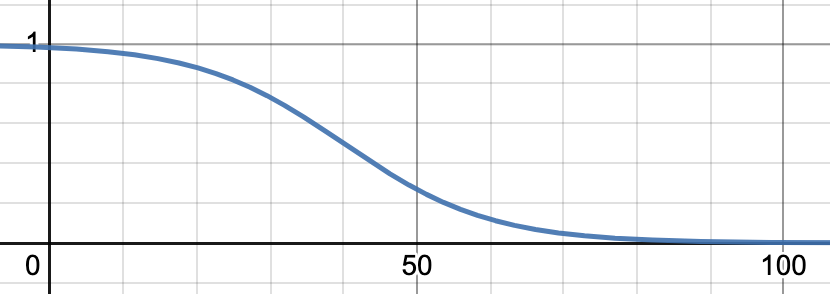

- Linear Model Progression
    - Simple addition
        - 25th percentile among candidates for $\alpha$
        - $\beta_{i} = 1$
    - Bayesian updating
        - Weakly informative priors on $\alpha$  and $\beta_{i}$
        - Update $LM$ with human/expert selected CH's
- Alternate Approaches
    - ACWE/LSE to refine candidate shapes

# Dead Ends

## Clustering

In [ ]:
edit_im = eqw_high_cut

mask = ~np.isnan(edit_im)
masked_array = get_masked_candidates(edit_im, mask)

plt.imshow(masked_array)

In [ ]:
ms = MeanShift().fit(masked_array)

In [ ]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

## Edge Detection

### Gradient Operators

In [ ]:
# 2x2 Roberts operator
edit_im = filters.roberts(eqw_high_cut)
peak_p = get_peak_percent(edit_im)
plot_thresholds(edit_im, bounds=[peak_p, 2, 5], threshold_type='lower')

In [ ]:
# 3x3 Sobel operator
edit_im = filters.sobel(eqw_high_cut)
peak_p = get_peak_percent(edit_im)
plot_thresholds(edit_im, bounds=[peak_p, 4, 8], threshold_type='lower')

In [ ]:
# 3x3 Prewitt operator
edit_im = filters.prewitt(eqw_high_cut)
peak_p = get_peak_percent(edit_im)
plot_thresholds(edit_im, bounds=[peak_p, 4, 8], threshold_type='lower')

### Laplace Operator

In [ ]:
edit_im = filters.laplace(eqw_high_cut)
peak_p = get_peak_percent(edit_im)
plot_thresholds(edit_im, bounds=[45, peak_p, 49], threshold_type='lower')

### Canny Detector

In [ ]:
edge_im = feature.canny(im_10p, sigma=10)
edge_im = np.where(edge_im, 1, 0)
np.histogram(edge_im)

In [ ]:
base_im = im_10p

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 30))
ax = axes.ravel()
    
for i in range(9):
    sigma = 3*(i + 1)
    edge_im = feature.canny(base_im, sigma=sigma)
    edge_im = np.where(edge_im, 1, 0)
    
    ax[i].imshow(edge_im)
    ax[i].title.set_text(f'Sigma: {sigma}')

## Frequency Domain

In [ ]:
def get_ft(image):
    ft = fft.ifftshift(image)
    ft = fft.fft2(ft)
    return fft.fftshift(ft)

def get_ift(image):
    ift = fft.ifftshift(image)
    ift = fft.ifft2(ift)
    ift = fft.fftshift(ift)
    return ift.real

def plot_freq_pass_filter(pass_type, radius_range):
    """Visualize frequency domain filter.
    """
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35, 35))
    ax = axes.ravel()

    for i in range(8):
        radius = int(radius_range[i])
        disk = morphology.disk(radius)

        # Create and center disk mask 
        pad_width = int((len(fourier_im) - len(disk) - 1)/2)
        disk_mask = np.pad(disk, pad_width=pad_width)
        if len(fourier_im) > len(disk_mask):
            disk_mask = np.pad(disk_mask, pad_width=(0,1))

        if pass_type == 'High':
            disk_mask = np.where((disk_mask == 0) | (disk_mask == 1), disk_mask^1, disk_mask)

        complex_disk_mask = np.empty(disk_mask.shape, dtype=np.complex128)
        complex_disk_mask.real = disk_mask
        complex_disk_mask.imag = disk_mask

        # Apply disk mask
        filt_fourier_im = fourier_im*complex_disk_mask

        rev_fourier_im = get_ift(filt_fourier_im)

        if i < 4:
            freq_i = i
            reg_i = i + 4
        else:
            freq_i = i + 4
            reg_i = i + 8

        ax[freq_i].imshow(np.log(abs(filt_fourier_im)), cmap=plt.cm.inferno)
        ax[freq_i].title.set_text(f'{radius}px {pass_type} Pass')
        ax[freq_i].axis('off')

        ax[reg_i].imshow(rev_fourier_im, cmap=plt.cm.gray)
        ax[reg_i].title.set_text(f'{radius}px {pass_type} Pass')
        ax[reg_i].axis('off')

        
def plot_butterworth_pass_filter(high_pass, cutoff_range):
    """Directly filter as high or low pass.
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))
    ax = axes.ravel()
    
    if high_pass:
        sign = '>'
    else:
        sign = '<'
    
    for i in range(9):
        cutoff = cutoff_range[i]
        high_pass_im = butterworth(im, cutoff_frequency_ratio=cutoff,
                                   high_pass=high_pass, channel_axis=None)
        ax[i].imshow(high_pass_im, cmap=plt.cm.gray)
        ax[i].title.set_text(f'{sign}{cutoff} Pass Filter')
        ax[i].axis('off')

In [ ]:
fourier_im = get_ft(raw_im)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.log(abs(fourier_im)), cmap=plt.cm.inferno)

In [ ]:
pass_type = 'High'
radius_range = np.linspace(1, 20, 8)
plot_freq_pass_filter(pass_type, radius_range)

In [ ]:
pass_type = 'Low'
radius_range = np.linspace(100, 10, 8)
plot_freq_pass_filter(pass_type, radius_range)